In [1]:
import cv2
import csv
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline

lines = []
with open('data/driving_log.csv') as csvfile:
  reader = csv.reader(csvfile)
  for line in reader:
    lines.append(line)
lines = lines[1:]
print(len(lines))

8036


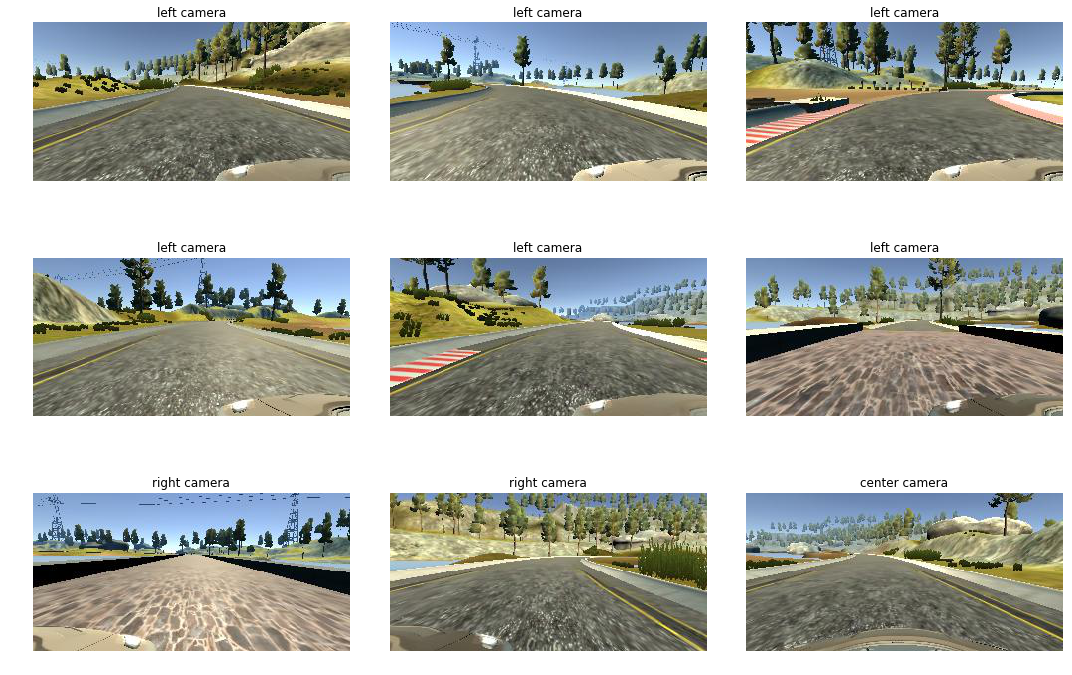

In [2]:
#idx: 3200, 4462, 3444
import matplotlib.gridspec as gridspec
samples = []

for k in range(9):
    idx = randint(0, len(lines))
    #print(idx)
    samples.append(lines[idx])

path = 'data/IMG/'
gs = gridspec.GridSpec(3,3)
gs.update(wspace=0.01, hspace=0.01) # set the spacing between axes.
plt.figure(figsize=(15,10))
title = ['center camera', 'left camera', 'right camera']
#print(sample)

for i in range(len(samples)):
    ax = plt.subplot(gs[i])
    plt.subplot(3,3,i+1)
    cam = randint(0,2)
    #print(cam)
    img = mpimg.imread(path + samples[i][cam].split('/')[-1])
    plt.title(title[cam])
    plt.imshow(img)
    plt.axis('off')
#plt.savefig('./writeup_images/class_{y}.png'.format(y = y_train[img_indices[i]]))
plt.tight_layout()
plt.savefig('examples/sample_images.png')
plt.show()


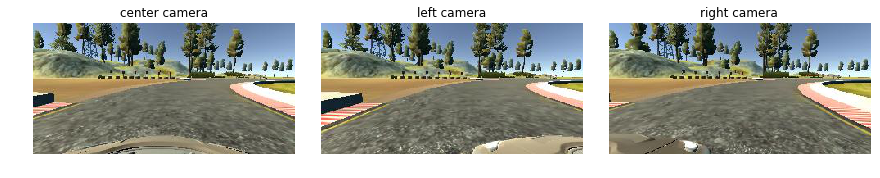

In [3]:
# Visualize the 3 camera images
index = 4462
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace = 0.1)
title = ['center camera', 'left camera', 'right camera']
for i in range(3):
    #img = mpimg.imread(path + sample[i].split('/')[-1])
    img_bgr = cv2.imread(path + lines[index][i].split('/')[-1])
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    #img = img_bgr[:,:,::-1]
    axes[i].imshow(img)
    axes[i].set_title(title[i])
    axes[i].axis('off')
fig.savefig('examples/sample_image_3_cams.png')


We next evaluate color spaces.

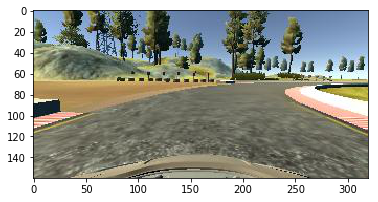

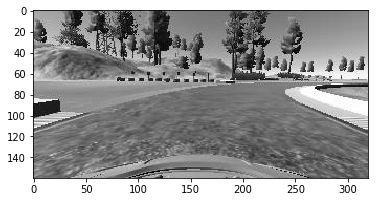

In [4]:
# Converting the RGB image to grayscale 
img =  mpimg.imread(path + lines[4462][0].split('/')[-1])
gray = cv2.cvtColor(img ,cv2.COLOR_RGB2GRAY)
plt.figure(1)
plt.imshow(img)
plt.savefig('examples/sample_image.png')
plt.figure(2)
plt.imshow(gray, cmap='gray')
#plt.axis('off')
plt.show()

Although conversion to grayscle reduces complexity of the data and the overall clutter, it does not provide any significant cues to identify the curvature of the road.  

So, we experiment with the HLS color space and check if the S channel gives us any useful information.

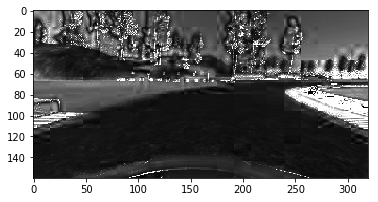

In [5]:
# RGB image to HLS
hls = cv2.cvtColor(img ,cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
plt.imshow(s_channel, cmap='gray')
plt.show()

The image above removes all the clutter from the road and only focuses on the sides of the road which gives us a lot of useful information reagrding the curvature of the road.  

Next, we crop the image to remove the top portion of the image and the front of the car. We can remove the top 55 pixels and the bottom 25 pixels.

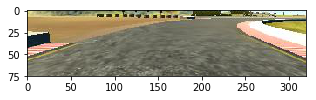

In [6]:
# cropping the image
def crop_image(image):
    return image[60:135, :, :]

cropped_img = crop_image(img)
plt.figure(figsize=(5,2))
plt.imshow(cropped_img)
plt.savefig('examples/cropped_image.png')
plt.show()

Track 1 is circular and during training I drove the car in the anti-clockwise direction. This leads to more number of left turns in than right turns. This could potentially bias our model to favor left turns. This can be observed form the histogram of the steering angles below.

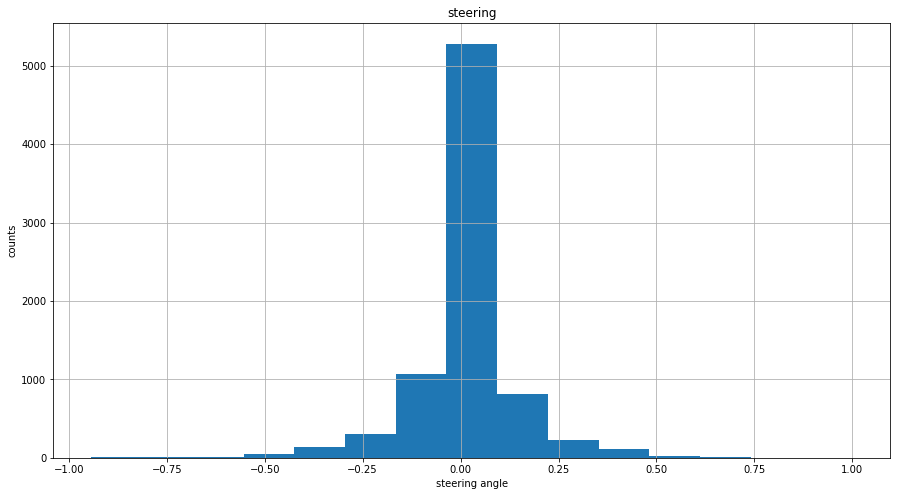

In [7]:
# Insert the histogram code
# Do this using pandas
with open('data/driving_log.csv') as csvfile:
    driving_log = pd.read_csv(csvfile)
driving_log.hist(column='steering', figsize=(15,8), bins=15)
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.savefig('examples/histogram.png')
plt.show()

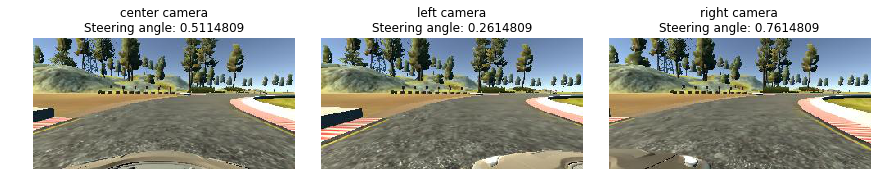

In [8]:
correction = 0.25
steering_center = driving_log['steering'][4462]
steering_left = steering_center  + correction
steering_right = steering_center  - correction
steering_angle = [steering_center, steering_right, steering_left]
fig, axes = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace = 0.1)
title = ['center camera', 'left camera', 'right camera']
for i in range(3):
    #img = mpimg.imread(path + sample[i].split('/')[-1])
    img_bgr = cv2.imread(path + lines[4462][i].split('/')[-1])
    img1 = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    #img = img_bgr[:,:,::-1]
    axes[i].imshow(img1)
    axes[i].set_title('%s\nSteering angle: %s'%(title[i], steering_angle[i]))
    axes[i].axis('off')
fig.savefig('examples/steering_angles.png')

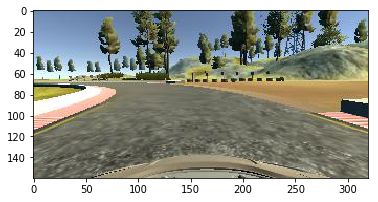

In [9]:
# Flip the image
def flip_image(image):
    return np.fliplr(image)

flipped_img = flip_image(img)
plt.imshow(flipped_img)
plt.savefig('examples/flipped_image')
plt.show()

To remove the bias, we can either drive in the opposite direction and add the images to te training data or we could employ a simple data augentation technique to flip all the images and reverse the steering angles to make the data more balanced.

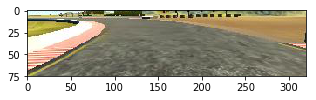

In [51]:
cropped_flipped_img = crop_image(flipped_img)
plt.figure(figsize=(5,2))
plt.imshow(cropped_flipped_img)
plt.savefig('examples/cropped_flipped_image')
plt.show()

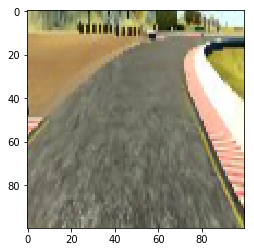

In [53]:
# Resize image
def resize_image(image):
    return cv2.resize(image,(100,100))

img =  mpimg.imread(path + lines[4462][0].split('/')[-1])
hls = cv2.cvtColor(img ,cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
s_channel = s_channel[60:135]

resized_img = resize_image(cropped_img)
plt.imshow(resized_img)
plt.savefig('examples/resized_image.png')
plt.show()

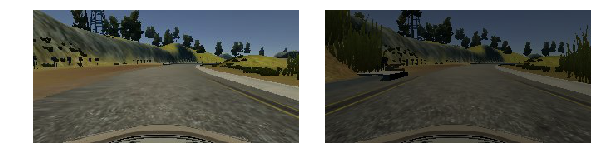

In [41]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace = 0.1)

for i in range(2):
    cam = randint(0,2)
    img = mpimg.imread(path + samples[i][cam].split('/')[-1])
    aug_img = augment_brightness_camera_images(img)
    axes[i].imshow(aug_img)
    axes[i].axis('off')
fig.savefig('examples/brightness_aug.png')